# Modelo analítico con Deep Learning para la predicción de mortalidad por COVID-19

## 1. Limpieza y preparación de los datos

**1.1 Carga librerias**

In [1]:
#importa librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from time import time
import itertools 

Using TensorFlow backend.


**1.2 Carga tabla de Diagnosticos**

In [2]:
#Carga datos de diagnosticos a dataframe
dfDiagnosticos = pd.read_csv("Diagnosticos4.csv",sep=";")
dfDiagnosticos.head()

,PersonaID,CodigoDiagnostico,NumeroAtenciones
0,25196249,B349,1
1,12725338,I10X,6
2,27448386,F200,23
3,307340,K050,1
4,42146268,K051,6


**1.3 Realiza pivot por columnas**

In [3]:
#Realiza pivot de columnas
dfDiagnosticos = dfDiagnosticos.pivot(index='PersonaID', columns='CodigoDiagnostico', values='NumeroAtenciones')

In [4]:
#Reemplaza NA con 0
dfDiagnosticos = dfDiagnosticos.fillna(0)

In [5]:
#Muestra datos
dfDiagnosticos.head()

CodigoDiagnostico,A000,A001,A009,A010,A011,A012,A013,A014,A020,A021,...,Y905,Y909,Y910,Y911,Y912,Y913,Y919,Y95X,Y96X,Y98X
PersonaID,,,,,,,,,,,,,,,,,,,,,
1241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
dfDiagnosticos.shape

(76572, 8112)

**1.4 Carga archivo de personas**

In [7]:
#Carga datos de personas a dataframe
dfPersonas = pd.read_csv("Personas4.csv",sep=";")
dfPersonas.head()

,PersonaID,Sexo,Edad,Departamento,Fallecido
0,103519292,M,27,41,0
1,27002945,M,58,41,0
2,122921680,M,25,41,0
3,46072617,M,53,41,0
4,32088936,F,52,05,0


In [8]:
dfPersonas.shape

(86000, 5)

**1.5 Transforma variables categóricas**

In [9]:
#Transforma variables categóricas
dfPersonas = pd.get_dummies(dfPersonas, columns=['Sexo'], prefix = ['Sexo'])
dfPersonas = pd.get_dummies(dfPersonas, columns=['Departamento'], prefix = ['Departamento'])
dfPersonas.head()

,PersonaID,Edad,Fallecido,Sexo_F,Sexo_M,Departamento_05,Departamento_06,Departamento_07,Departamento_08,Departamento_09,...,Departamento_85,Departamento_86,Departamento_87,Departamento_88,Departamento_91,Departamento_94,Departamento_95,Departamento_97,Departamento_99,Departamento_NR
0,103519292,27,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,27002945,58,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,122921680,25,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,46072617,53,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,32088936,52,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**1.6 Realiza join entre los dos archivos**

In [10]:
#Realiza join entre los dos dataframes
dfConsolidado = pd.merge(dfDiagnosticos, dfPersonas, on='PersonaID', how='right')
dfConsolidado.head()

,PersonaID,A000,A001,A009,A010,A011,A012,A013,A014,A020,...,Departamento_85,Departamento_86,Departamento_87,Departamento_88,Departamento_91,Departamento_94,Departamento_95,Departamento_97,Departamento_99,Departamento_NR
0,1241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,1675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,6647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
dfConsolidado.shape

(86000, 8169)

**1.7 Genera archivo para modelo**

In [12]:
#dfConsolidado.to_csv('DatosERC.csv',sep=',',index=False)

## 2. Modelado de la red neuronal

**2.1 Selección de features**

In [13]:
#Reemplaza NA con 0
dfDatosERC = dfConsolidado.fillna(0)

#Retira columna de ID
dfDatosERC = dfDatosERC.drop(['PersonaID'], axis=1)

#Muestra primeras 5 lineas
dfDatosERC.head()

,A000,A001,A009,A010,A011,A012,A013,A014,A020,A021,...,Departamento_85,Departamento_86,Departamento_87,Departamento_88,Departamento_91,Departamento_94,Departamento_95,Departamento_97,Departamento_99,Departamento_NR
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


**2.2 Separación de features (x) y etiquetas (y)**

In [14]:
#Separa datos x(features) vs y(clase)
y = dfDatosERC['Fallecido']
x = dfDatosERC.drop(['Fallecido'], axis=1)

In [15]:
#Normaliza datos en x
x = (x - x.min()) / (x.max() - x.min())

**2.3 Conjuntos de datos de entrenamiento y pruebas**

In [16]:
#Separa datos de entrenamiento y pruebas
entrenamientoX, pruebasX, entrenamientoY, pruebasY = train_test_split(
    x,y, test_size= 0.30, random_state=2)
entrenamientoX.head()

,A000,A001,A009,A010,A011,A012,A013,A014,A020,A021,...,Departamento_85,Departamento_86,Departamento_87,Departamento_88,Departamento_91,Departamento_94,Departamento_95,Departamento_97,Departamento_99,Departamento_NR
80937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63440,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
73563,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
#Gráfica del loss y el accuracy

def plot_acc(history, title="Model Accuracy"):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    plt.plot(history1.history['acc'], color="green")
    plt.plot(history1.history['val_acc'], 'r--', color="green")
    plt.plot(history2.history['acc'], color="blue")
    plt.plot(history2.history['val_acc'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

**2.11 Modelo final**

In [78]:
#Entrena modelo final
tiempo_inicial = time() 

#Definición del modelo
model_final = Sequential()
model_final.add(Dense(units=500, activation='relu', input_dim=entrenamientoX.shape[1]))
model_final.add(Dropout(0.5))
model_final.add(Dense(units=100, activation='relu'))
model_final.add(Dropout(0.5))
model_final.add(Dense(units=50, activation='relu'))
model_final.add(Dropout(0.5))
model_final.add(Dense(units=1, activation='sigmoid'))

#compilación del modelo
model_final.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

#Agrega early stopping
#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

#entrenamiento del modelo
#history_final=model_final.fit(entrenamientoX, entrenamientoY, validation_split=0.2, epochs=5, batch_size=1000, callbacks=[es])
history_final=model_final.fit(entrenamientoX, entrenamientoY, validation_split=0.2, epochs=5, batch_size=1000)

tiempo_final = time() 
print ('El tiempo de ejecucion fue:', tiempo_final-tiempo_inicial, "segundos")

Train on 48160 samples, validate on 12040 samples
Epoch 1/5
48160/48160 [==============================] - 32s 668us/step - loss: 0.5160 - acc: 0.7507 - val_loss: 0.3106 - val_acc: 0.8713
Epoch 2/5
48160/48160 [==============================] - 31s 634us/step - loss: 0.3095 - acc: 0.8783 - val_loss: 0.2956 - val_acc: 0.8762
Epoch 3/5
48160/48160 [==============================] - 31s 637us/step - loss: 0.2790 - acc: 0.8895 - val_loss: 0.2974 - val_acc: 0.8766
Epoch 4/5
48160/48160 [==============================] - 30s 630us/step - loss: 0.2627 - acc: 0.8978 - val_loss: 0.3097 - val_acc: 0.8728
Epoch 5/5
48160/48160 [==============================] - 30s 628us/step - loss: 0.2508 - acc: 0.9008 - val_loss: 0.3064 - val_acc: 0.8762
El tiempo de ejecucion fue: 154.64389657974243 segundos


In [79]:
#Realiza prediccion en conjunto pruebas
score = model_final.evaluate(pruebasX, pruebasY)

#Obtiene el accuracy del modelo final
print("Valor de accuracy en conjunto de datos de test: ",score[1])

25800/25800 [==============================] - 9s 352us/step
Valor de accuracy en conjunto de datos de test:  0.8807751937984496


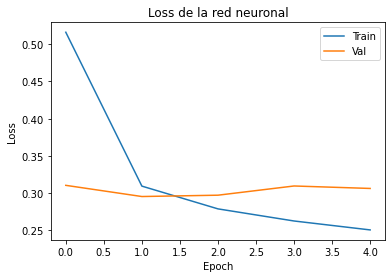

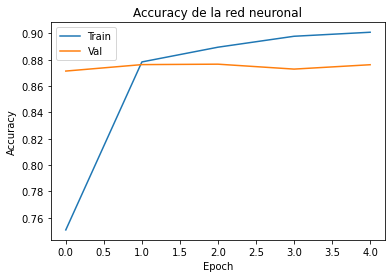

In [80]:
plot_loss(history_final, title="Loss de la red neuronal")    
plot_acc(history_final, title="Accuracy de la red neuronal")

In [81]:
#Guarda modelo final
model_final.save('modelo_Red_Neuronal_COVID_RIPS4.h5')
#model_final = keras.models.load_model('modelo_Red_Neuronal_ERC.h5')

## 3. Evaluación del modelo

**3.1 Matriz de confusión**

In [82]:
#Obtiene valores predichos para el conjunto de pruebas
scores = model_final.predict(pruebasX, verbose=0)
prediccion = np.round(scores).astype(int)
prediccion

array([[1],
       [0],
       [1],
       ...,
       [0],
       [1],
       [0]])

In [83]:
#Genera matriz de confusión
cf = confusion_matrix(prediccion, pruebasY)
cf

array([[11301,  1399],
       [ 1677, 11423]], dtype=int64)

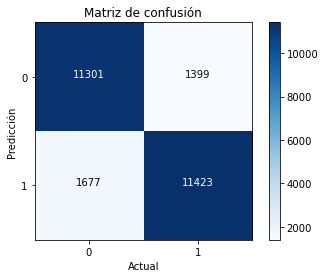

In [84]:
#Grafica matriz de confusión
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Matriz de confusión')
plt.xlabel('Actual')
plt.ylabel('Predicción')
tick_marks = np.arange(len(set(pruebasY))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

**3.2 Precision, Recall y F1-score**

In [85]:
#Obtiene metricas
tp=cf[1,1]
tn=cf[0,0]
fp=cf[1,0]
fn=cf[0,1]
print("La metrica de sensibilidad para el modelo es de:",round(tp/(tp+fn),2))
print("La metrica de especificidad para el modelo es de:",round(tn/(tn+fp),2))
pre=round(tp/(tp+fp),2)
print("La metrica de precision para el modelo es de:",pre)
rec=round(tp/(tp+fn),2)
print("La metrica de recall para el modelo es de:",rec)
print("La metrica de f1-score para el modelo es de:",round( (2*pre*rec)/(pre+rec),2) )

La metrica de sensibilidad para el modelo es de: 0.89
La metrica de especificidad para el modelo es de: 0.87
La metrica de precision para el modelo es de: 0.87
La metrica de recall para el modelo es de: 0.89
La metrica de f1-score para el modelo es de: 0.88


**3.3 Curva ROC/AUC**

In [86]:
#Obtiene AUC
auc=roc_auc_score(pruebasY, scores)
print("El AUC es de:",auc)

El AUC es de: 0.9482215610839351


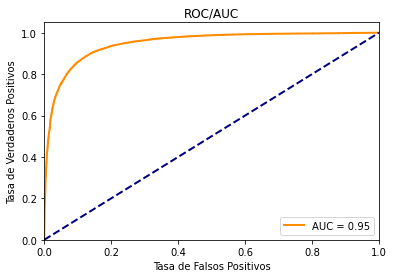

In [89]:
#Genera ROC
fpr, tpr, thresholds = roc_curve(pruebasY, scores)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('ROC/AUC')
plt.legend(loc="lower right")
plt.show()

## 4. Comparación con random forest

**4.1 Entrenamiento con Random Forest**

In [59]:
#Realiza entrenamiento con Random Forest
clfRF = RandomForestClassifier(n_estimators=5)
clfRF.fit(entrenamientoX, entrenamientoY)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [60]:
#Muestra las features mas importantes
importancia = pd.DataFrame(columns=('variable', 'importancia'))
cont=0
for i in pruebasX.columns:
    importancia.loc[len(importancia)]=[i,clfRF.feature_importances_[cont]] 
    cont=cont+1
importancia=importancia.sort_values(by=['importancia'], ascending=[False])
print(importancia[:20])

     variable  importancia
8112     Edad     0.273151
2744     I10X     0.094111
1414     E109     0.027660
4740     N40X     0.022811
3210     J449     0.022095
1585     E669     0.010785
1424     E119     0.010263
1581     E660     0.007944
1454     E149     0.007802
1413     E108     0.007176
4668     N189     0.006762
4733     N390     0.006752
2451     H259     0.006509
3305     K021     0.006255
8114   Sexo_M     0.005461
2895     I500     0.005459
8113   Sexo_F     0.005277
3208     J441     0.005016
3333     K051     0.005007
52       A09X     0.004746


**4.2 Pruebas del modelo con Random Forest**

In [61]:
#Realiza prediccion en conjunto pruebas con Random Forest
scores=clfRF.predict(pruebasX)
prediccionRF=np.round(scores).astype(int)
prediccionRF

array([0, 0, 1, ..., 0, 1, 0])

**4.3 Evaluación de resultados con Random Forest**

In [62]:
#Genera matriz de confusión
cf = confusion_matrix(prediccionRF, pruebasY)
cf

array([[11185,  1690],
       [ 1793, 11132]], dtype=int64)

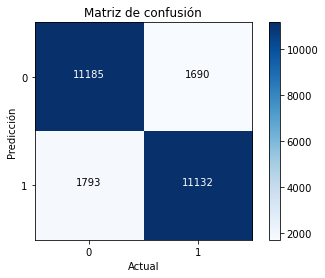

In [63]:
#Grafica matriz de confusión
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Matriz de confusión')
plt.xlabel('Actual')
plt.ylabel('Predicción')
tick_marks = np.arange(len(set(pruebasY))) # length of classes
class_labels = ['0','1']
tick_marks
plt.xticks(tick_marks,class_labels)
plt.yticks(tick_marks,class_labels)
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show();

In [64]:
#Obtiene el accuracy del modelo final
print("Valor de accuracy en conjunto de datos de test: ",round((cf[0,0]+cf[0,0])/sum(sum(cf))*100,2))

Valor de accuracy en conjunto de datos de test:  86.71


In [65]:
#Obtiene metricas
tp=cf[1,1]
tn=cf[0,0]
fp=cf[1,0]
fn=cf[0,1]
print("La metrica de sensibilidad para el modelo es de:",round(tp/(tp+fn),2))
print("La metrica de especificidad para el modelo es de:",round(tn/(tn+fp),2))
pre=round(tp/(tp+fp),2)
print("La metrica de precision para el modelo es de:",pre)
rec=round(tp/(tp+fn),2)
print("La metrica de recall para el modelo es de:",rec)
print("La metrica de f1-score para el modelo es de:",round( (2*pre*rec)/(pre+rec),2) )
auc=roc_auc_score(pruebasY, scores)
print("El AUC es de:",auc)

La metrica de sensibilidad para el modelo es de: 0.87
La metrica de especificidad para el modelo es de: 0.86
La metrica de precision para el modelo es de: 0.86
La metrica de recall para el modelo es de: 0.87
La metrica de f1-score para el modelo es de: 0.86
El AUC es de: 0.8650192042355541
